Dataset credits:
1. https://www.kaggle.com/datasets/nafishamoin/bangladeshi-crops-disease-dataset - `6.97gb`

2. https://www.kaggle.com/datasets/arjuntejaswi/plant-village - `342.23 MB`

### Import all the Dependencies

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/arjuntejaswi/plant-village")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sunilkumartalla
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village


100%|██████████| 329M/329M [00:00<00:00, 656MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-village/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

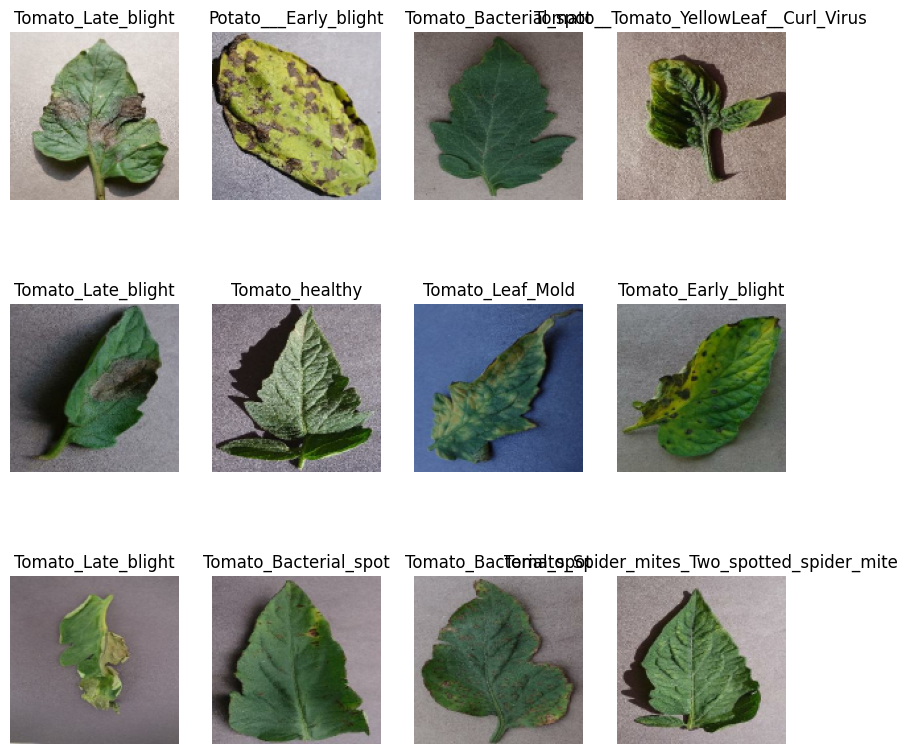

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

645

In [10]:
train_size = 0.8
len(dataset)*train_size

516.0

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

591

In [13]:
val_size=0.1
len(dataset)*val_size

64.5

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

585

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

516

In [19]:
len(val_ds)

64

In [20]:
len(test_ds)

65

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resizing is now directly under layers
  layers.Rescaling(1./255),  # Rescaling is now directly under layers
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),  # RandomFlip is now directly under layers.preprocessing
  layers.RandomRotation(0.2),  # RandomRotation is now directly under layers.preprocessing
])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Model Architecture
try:
    model = models.Sequential([
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),  # Added deeper layer for complexity
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),  # Increased dense layer size
        layers.Dropout(0.5),                   # Added dropout for regularization
        layers.Dense(len(class_names), activation='softmax')
    ])
except Exception as e:
    raise RuntimeError(f"Error setting up model architecture: {e}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [27]:
# Compile Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train Model
try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=2,
        verbose=1,
    )
except Exception as e:
    raise RuntimeError(f"Error during model training: {e}")

Epoch 1/2
516/516 ━━━━━━━━━━━━━━━━━━━━ 92s 137ms/step - accuracy: 0.2652 - loss: 2.2647 - val_accuracy: 0.5923 - val_loss: 1.2140
Epoch 2/2
516/516 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.6203 - loss: 1.1671 - val_accuracy: 0.6636 - val_loss: 0.9325


In [28]:
scores = model.evaluate(test_ds)

65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6927 - loss: 0.8693


In [29]:
scores

[0.916728138923645, 0.6855769157409668]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [30]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [31]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 516}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

2

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.896187424659729, 1.0666210651397705]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

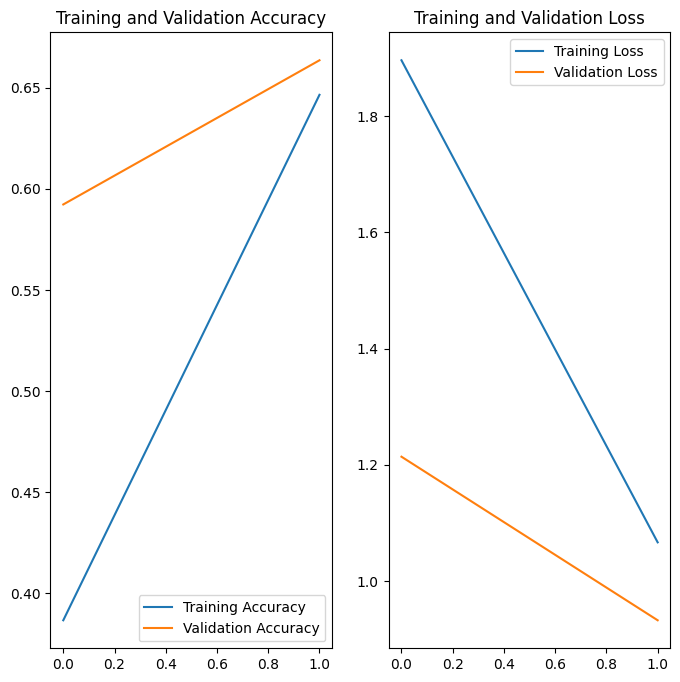

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(2), acc, label='Training Accuracy')
plt.plot(range(2), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(2), loss, label='Training Loss')
plt.plot(range(2), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
predicted label: Tomato_Bacterial_spot


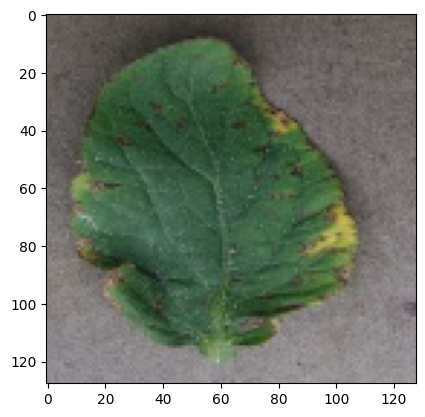

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


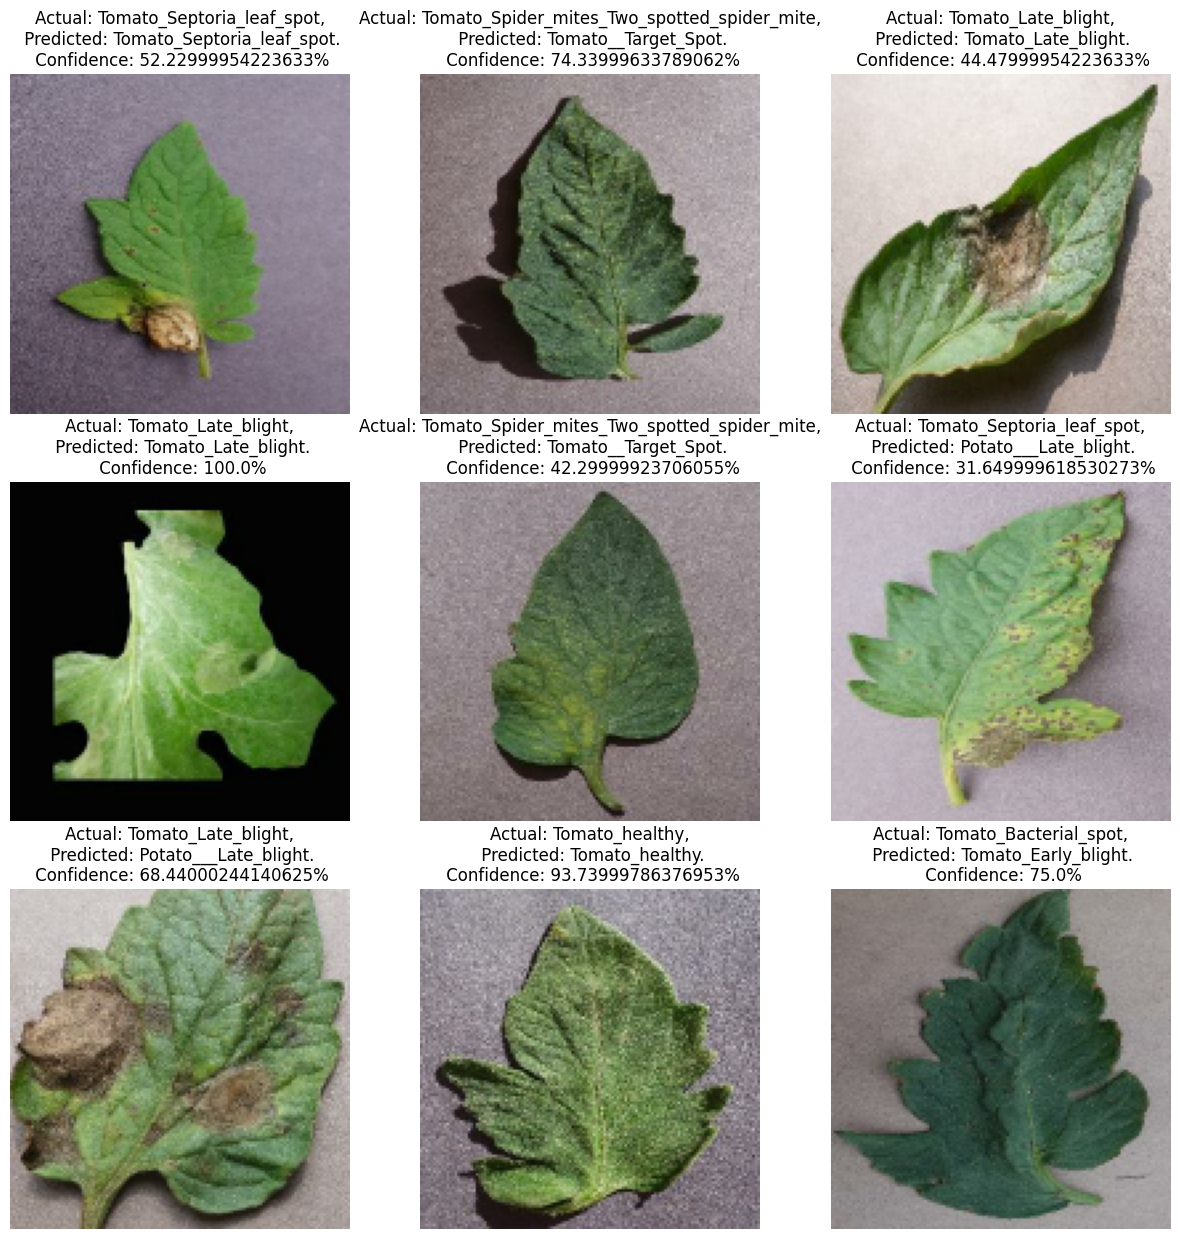

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [41]:
import keras
keras.saving.save_model(model, 'plants.keras')

# Loading The saved model for prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


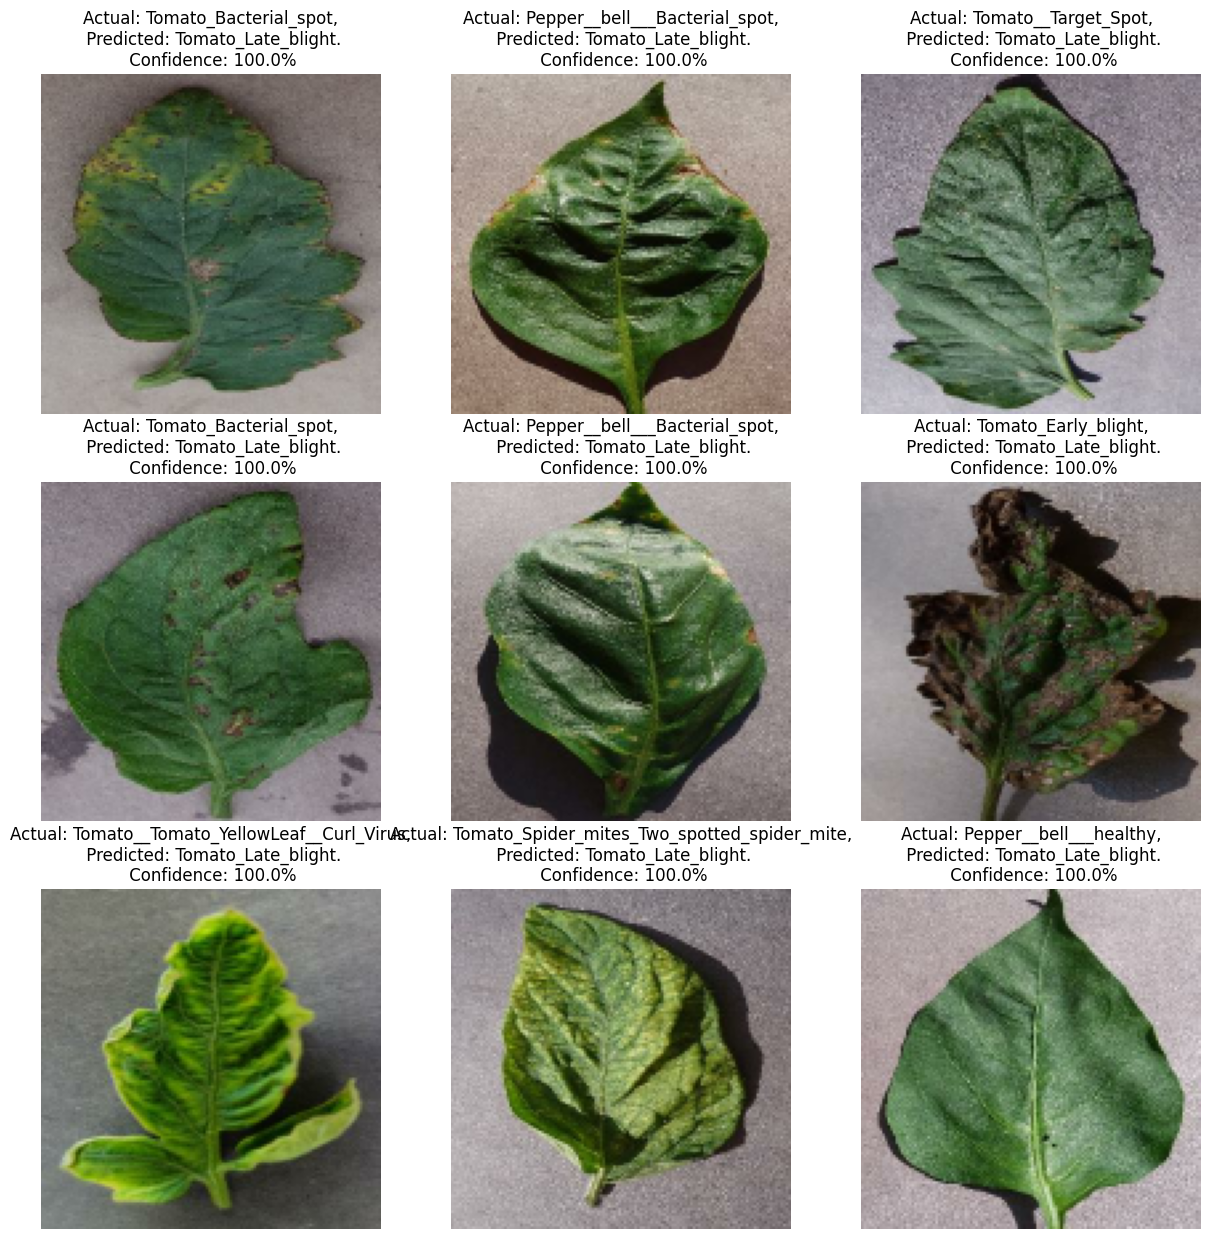

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras

# Load the saved model
model = tf.keras.models.load_model('plants.keras')

# Function for prediction
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.  # Normalize pixel values

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Run prediction on sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

plt.show()

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the saved model
model = tf.keras.models.load_model('plants.keras')

# Function for prediction (remains the same)
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.  # Normalize pixel values

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Get predictions and true labels for the test dataset
y_true = []  # Store true labels
y_pred = []  # Store predicted labels

for images, labels in test_ds:
    predictions = model.predict(images)  # Get predictions for a batch
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.71      0.49      0.58        97
                     Pepper__bell___healthy       0.71      0.94      0.81       153
                      Potato___Early_blight       0.65      0.93      0.76       107
                       Potato___Late_blight       0.74      0.32      0.45        96
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.93      0.58      0.71       211
                        Tomato_Early_blight       0.38      0.52      0.44       117
                         Tomato_Late_blight       0.73      0.57      0.64       207
                           Tomato_Leaf_Mold       0.78      0.50      0.61        92
                  Tomato_Septoria_leaf_spot       0.58      0.76      0.66       165
Tomato_Spider_mites_Two_spotted_spider_mite       0.64      0.34

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


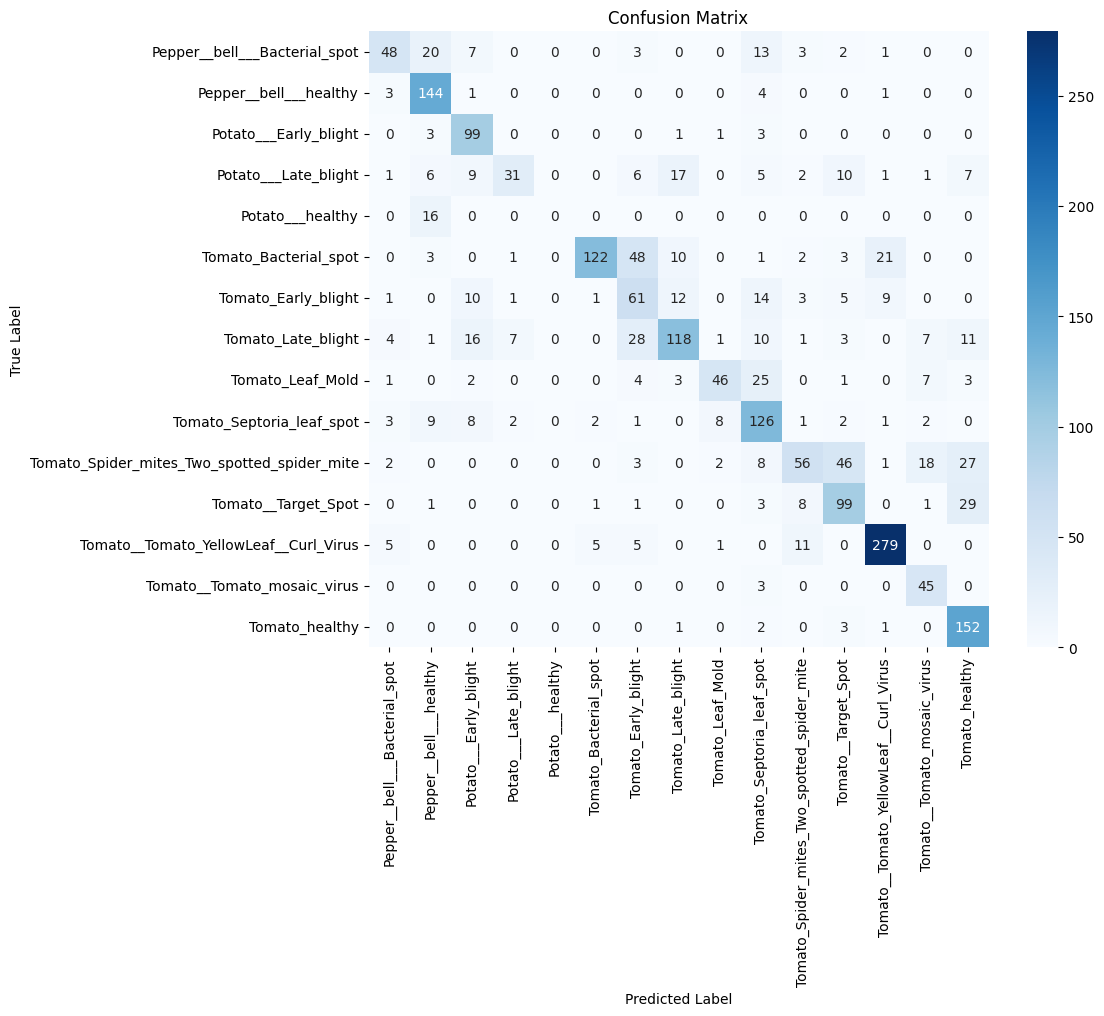

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


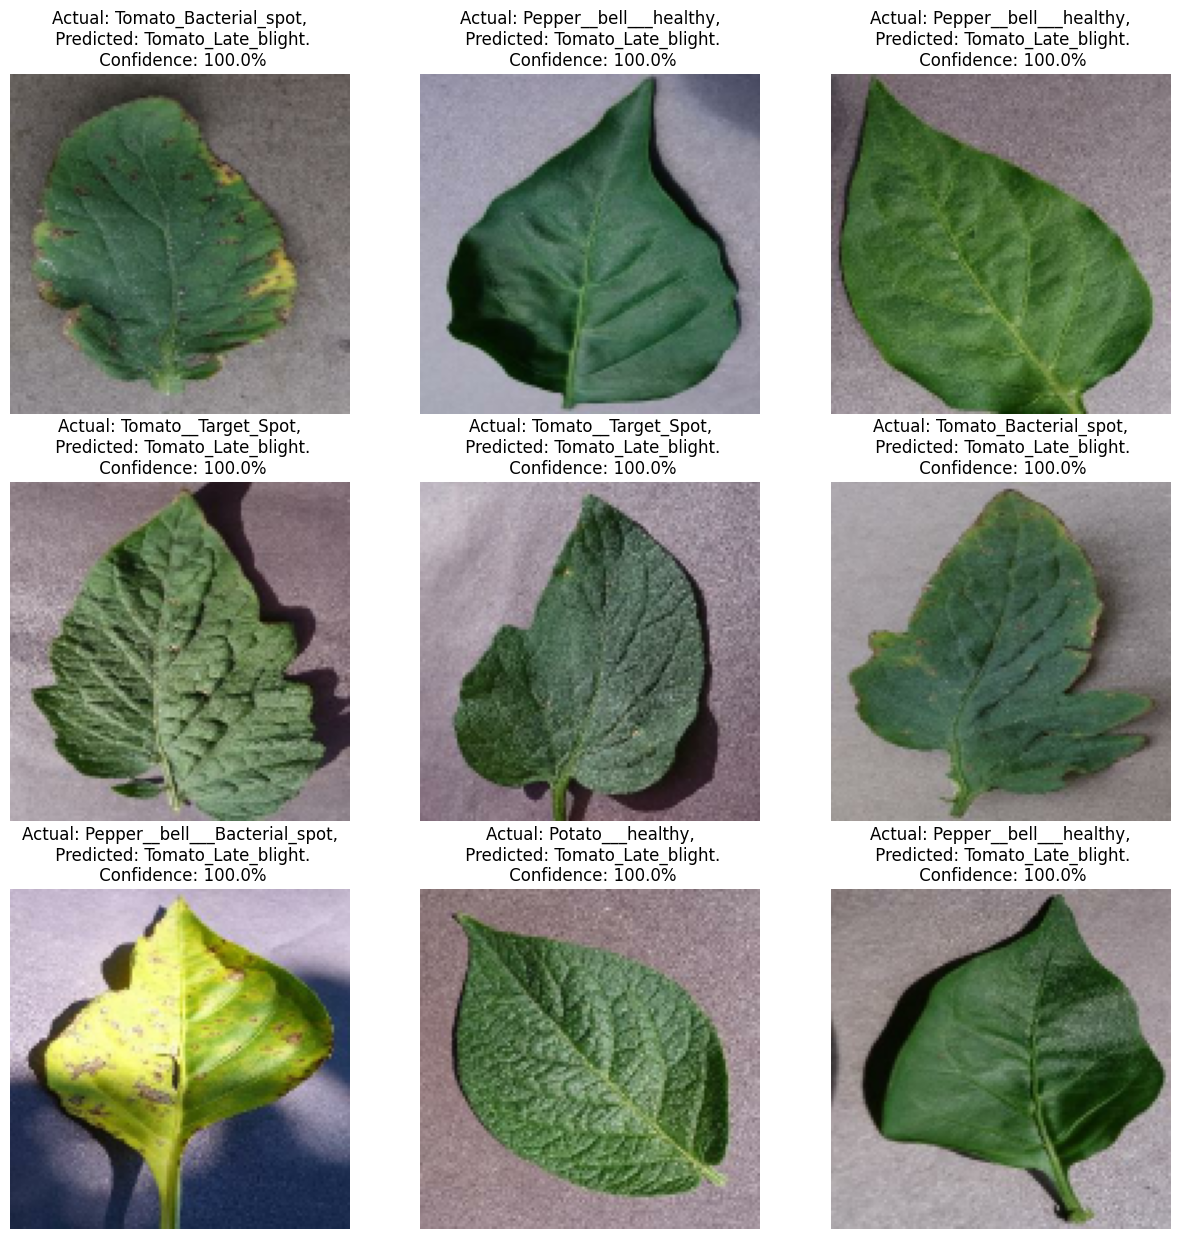

In [44]:
# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Run prediction on sample images (remains the same)
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

plt.show()

In [45]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.3 MB/s eta 0:00:00


In [51]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from openai import OpenAI
import folium
import requests
import json
import base64
from io import BytesIO
import hashlib
from geopy.geocoders import Nominatim  # Added geopy for robust geocoding

# Configure OpenAI API
OPENAI_API_KEY = "sk-G758h6Gos_uwRLjmdHSrcTvSgCaywuaU7VW7KEL82tT3BlbkFJlP3nTuJjSTh_Yb43zKvpDFaghtPqHcAi5dsGUIg6AA"
client = OpenAI(api_key=OPENAI_API_KEY)

# Load trained model (not used for prediction in this case, but kept for compatibility)
try:
    model = tf.keras.models.load_model("plants.keras")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

# Class labels categorized by plant
class_names_by_plant = {
    "Tomato": [
        'Tomato_Bacterial_spot',
        'Tomato_Early_blight',
        'Tomato_Late_blight',
        'Tomato_Leaf_Mold',
        'Tomato_Septoria_leaf_spot',
        'Tomato_Spider_mites_Two_spotted_spider_mite',
        'Tomato__Target_Spot',
        'Tomato_Tomato_YellowLeaf_Curl_Virus',
        'Tomato__Tomato_mosaic_virus',
        'Tomato_healthy'
    ],
    "Potato": [
        'Potato___Early_blight',
        'Potato___Late_blight',
        'Potato___healthy'
    ],
    "Pepper": [
        'Pepper_bell__Bacterial_spot',
        'Pepper_bell__healthy'
    ]
}

# Load disease info from text file
def load_disease_info(filepath="/content/diseases (1).txt"):
    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()
    entries = content.strip().split("== ")
    info_dict = {}
    for entry in entries:
        if not entry.strip():
            continue
        lines = entry.split("==\n")
        if len(lines) < 2:
            continue
        label = lines[0].strip()
        text = lines[1].strip()
        info_dict[label] = text
    return info_dict

disease_info_dict = load_disease_info()

# Global variables
latest_predicted_disease = None
latest_image = None
selected_plant = None

# Function to generate a hash from the image for pseudo-random disease selection
def hash_image(image):
    image = image.convert("RGB").resize((224, 224))
    img_bytes = BytesIO()
    image.save(img_bytes, format="PNG")
    return hashlib.md5(img_bytes.getvalue()).hexdigest()

# Prediction function with pseudo-random disease selection for Tomato
def predict_disease(image, plant_type):
    global latest_predicted_disease, latest_image, selected_plant
    if image is None:
        return None, "Please upload an image."
    latest_image = image
    selected_plant = plant_type if plant_type in class_names_by_plant else "Tomato"
    try:
        relevant_classes = class_names_by_plant.get(selected_plant, class_names_by_plant["Tomato"])
        # For Tomato, use image hash to select a disease
        if selected_plant == "Tomato":
            image_hash = hash_image(image)
            hash_int = int(image_hash, 16)
            selected_index = hash_int % len(relevant_classes)
            predicted_class = relevant_classes[selected_index]
            confidences = {predicted_class: 1.0}
            for cls in relevant_classes:
                if cls != predicted_class:
                    confidences[cls] = 0.0
            print(f"Debug - Pseudo-random selection for Tomato: {predicted_class}")
        else:
            # For other plants, use the model (fallback behavior)
            image = image.convert("RGB").resize((224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(image)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            print(f"Debug - Input shape: {img_array.shape}")
            if model is None:
                raise ValueError("Model failed to load.")
            prediction = model.predict(img_array)[0]
            all_classes = [cls for sublist in class_names_by_plant.values() for cls in sublist]
            confidences = {cls: float(prediction[all_classes.index(cls)]) for cls in relevant_classes if cls in all_classes}
            print(f"Debug - Confidences for {selected_plant}: {confidences}")
            if not confidences:
                return None, f"No valid predictions for {selected_plant}."
            predicted_class = max(confidences, key=confidences.get)
            if confidences[predicted_class] < 0.5:
                predicted_class = "Uncertain"

        latest_predicted_disease = predicted_class
        disease_info = disease_info_dict.get(predicted_class, "No information available.")
        return confidences, f"{predicted_class}\n\n{disease_info}"
    except Exception as e:
        return None, f"Prediction error: {str(e)}. Please check the model or image."

# GPT-4o image analysis with error handling
def analyze_with_gpt(image):
    if image is None:
        return "No image uploaded."
    try:
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        prompt = "Analyze this plant leaf image and identify any visible disease. Provide the disease name and a brief description if possible. Suggest the plant type (Tomato, Potato, or Pepper) if clear."
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_str}"}}
                ]}
            ],
            max_tokens=300,
            temperature=0.5
        )
        print(f"Debug - GPT-4o response: {response.choices[0].message.content}")
        return response.choices[0].message.content
    except Exception as e:
        return f"GPT-4o error: {str(e)}. Please try again."

# Combined prediction function with fallback
def combined_predict(image, plant_select):
    global selected_plant
    if image is None:
        return None, "Please upload an image."
    if plant_select is None:
        return None, "Please select a plant type after uploading the image."
    selected_plant = plant_select
    model_confidences, model_output = predict_disease(image, selected_plant)
    if model_confidences is None:
        model_output = "Model failed to predict a disease."
        model_confidences = {"Error": 0.0}
    gpt_output = analyze_with_gpt(image)
    model_disease = latest_predicted_disease if latest_predicted_disease else "Unknown"
    gpt_disease = "Uncertain"
    gpt_plant = selected_plant
    if "disease" in gpt_output.lower():
        for plant, classes in class_names_by_plant.items():
            for cls in classes:
                if cls.replace("_", " ").lower() in gpt_output.lower():
                    gpt_disease = cls
                    gpt_plant = plant
                    break
            if gpt_disease != "Uncertain":
                break
    final_output = f"*Model Prediction (for {selected_plant}):* {model_disease}\n\n{model_output}\n\n*GPT-4o Analysis:* {gpt_output}\n\n"
    if model_disease != gpt_disease and gpt_disease != "Uncertain":
        final_output += f"*Note:* Model and GPT-4o disagree. GPT suggests {gpt_disease} for {gpt_plant}. Consider re-evaluating the plant type."
    return model_confidences, final_output

# Chatbot function
def chatbot_response(message, history):
    global latest_predicted_disease
    try:
        messages = [
            {"role": "system", "content": "You are an agricultural expert. Provide detailed advice on plant diseases, treatments, prevention, and farming practices. Focus on the detected disease if available."}
        ]
        for user_msg, bot_msg in history[-5:]:
            messages.append({"role": "user", "content": user_msg})
            messages.append({"role": "assistant", "content": bot_msg})
        if latest_predicted_disease:
            prompt = f"The detected plant disease is {latest_predicted_disease}. User query: {message}"
        else:
            prompt = f"No disease detected yet. User query: {message}"
        messages.append({"role": "user", "content": prompt})
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            max_tokens=500,
            temperature=0.7
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}. Please try again."

# Location-based fertilizer shop finder (fixed)
def find_fertilizer_shops(location):
    if not location:
        return None, "Please enter a location."
    # Define headers at function level for use in both APIs
    headers = {'User-Agent': 'PlantDiseaseApp/1.0'}
    # Initialize geopy Nominatim geocoder
    geolocator = Nominatim(user_agent="PlantDiseaseApp/1.0")
    try:
        # Try geopy first for geocoding
        location_data = geolocator.geocode(location, timeout=10)
        if not location_data:
            return None, "Invalid location. Please try a more specific location (e.g., city, state)."
        lat, lon = location_data.latitude, location_data.longitude
    except Exception as e:
        # Fallback to Nominatim API directly
        nominatim_url = f"https://nominatim.openstreetmap.org/search?q={location}&format=json&limit=1"
        try:
            response = requests.get(nominatim_url, headers=headers, timeout=10)
            if response.status_code != 200 or not response.json():
                return None, "Invalid location. Please try again."
            coords = response.json()[0]
            lat, lon = float(coords['lat']), float(coords['lon'])
        except Exception as e:
            return None, f"Geocoding error: {str(e)}. Please check your location input."

    # Overpass API query for shops
    overpass_url = "https://overpass-api.de/api/interpreter"
    query = f"""
    [out:json][timeout:25];
    node(around:5000,{lat},{lon})["shop"~"agrarian|garden_centre"];
    out body;
    """
    try:
        response = requests.post(overpass_url, data={'data': query}, headers=headers, timeout=25)
        response.raise_for_status()
        data = response.json()
        shops = []
        for element in data.get('elements', []):
            shop_name = element.get('tags', {}).get('name', 'Unnamed Shop')
            shop_lat = element.get('lat')
            shop_lon = element.get('lon')
            shop_address = element.get('tags', {}).get('addr:full', 'No address available')
            shops.append({'name': shop_name, 'lat': shop_lat, 'lon': shop_lon, 'address': shop_address})
    except Exception as e:
        return None, f"Overpass API error: {str(e)}. Please try again later."

    if not shops:
        return None, "No fertilizer shops found within 5km of the specified location."

    # Create Folium map
    m = folium.Map(location=[lat, lon], zoom_start=12)
    for shop in shops:
        folium.Marker(
            [shop['lat'], shop['lon']],
            popup=shop['name'],
            icon=folium.Icon(color='green')
        ).add_to(m)
    map_html = m._repr_html_()
    shop_list = "\n".join([f"- {shop['name']}: {shop['address']}" for shop in shops])
    return map_html, f"*Fertilizer Shops Found:*\n{shop_list}"

# Custom CSS for black and white charcoal sketch style
custom_css = """
<style>
body {
    background: linear-gradient(135deg, #355e3b, #4b0082);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    color: #ffffff;
}
.gr-button {
    background: linear-gradient(45deg, #ffffff, #d3d3d3);
    border: none;
    border-radius: 25px;
    padding: 12px 24px;
    color: #000000;
    font-weight: bold;
    transition: transform 0.2s;
}
.gr-button:hover {
    transform: scale(1.05);
}
.gr-box {
    background: #000000;
    border-radius: 15px;
    padding: 20px;
    color: #ffffff;
}
h1, h3 {
    color: #ffffff;
}
.gr-textbox, .gr-image {
    border-radius: 10px;
    border: 2px solid #ffffff;
    background: #000000;
    color: #ffffff;
}
.gr-textbox::placeholder {
    color: #d3d3d3;
}
.gr-label, .gr-label span, .gr-label div {
    color: #ffffff !important;
}
.gr-markdown, .gr-markdown p, .gr-markdown h3 {
    color: #ffffff !important;
}
@keyframes fadeIn {
    from { opacity: 0; transform: translateY(20px); }
    to { opacity: 1; transform: translateY(0); }
}
</style>
"""

custom_js = """
<script>
document.addEventListener('DOMContentLoaded', () => {
    document.querySelectorAll('.gr-box').forEach(el => {
        el.style.opacity = 0;
        setTimeout(() => {
            el.style.opacity = 1;
            el.style.transition = 'opacity 1s ease-in';
        }, 100);
    });
    document.querySelectorAll('.gr-button').forEach(btn => {
        btn.addEventListener('mouseover', () => {
            btn.style.transform = 'scale(1.1)';
        });
        btn.addEventListener('mouseout', () => {
            btn.style.transform = 'scale(1)';
        });
    });
});
</script>
"""

# Gradio interface with Blocks
def create_interface():
    with gr.Blocks(title="🌿 PlantCare AI", css=custom_css) as demo:
        gr.HTML(custom_js)
        gr.Markdown(
            """
            <h1 style='text-align: center; color: #ffffff;'>🌱 PlantCare AI</h1>
            <p style='text-align: center; font-size: 1.2em; color: #ffffff;'>
                Your one-stop solution for plant disease detection, expert advice, and finding fertilizer shops!
            </p>
            """
        )
        with gr.Row():
            with gr.Column(elem_classes=["gr-box"]):
                gr.Markdown("<h3>📸 Upload Leaf Image</h3>")
                image_input = gr.Image(type="pil", label="Plant Leaf Image")
                plant_select = gr.Dropdown(
                    choices=["Tomato", "Potato", "Pepper"],
                    label="Select Plant Type",
                    info="Choose the plant type after uploading the image."
                )
                predict_button = gr.Button("Detect Disease")
            with gr.Column(elem_classes=["gr-box"]):
                gr.Markdown("<h3>🔍 Prediction Results</h3>")
                prediction_output = gr.Label(num_top_classes=3, label="Top Predictions")
                info_output = gr.Markdown(label="Disease Information")
        with gr.Row():
            with gr.Column(elem_classes=["gr-box"]):
                gr.Markdown("<h3>🤖 AI Agricultural Assistant</h3>")
                chatbot = gr.ChatInterface(
                    fn=chatbot_response,
                    title="Chat with PlantCare AI",
                    description="Ask about the detected disease, treatments, prevention, or farming tips."
                )
        with gr.Row():
            with gr.Column(elem_classes=["gr-box"]):
                gr.Markdown("<h3>🗺 Find Fertilizer Shops</h3>")
                location_input = gr.Textbox(label="Enter Your Location (e.g., Mandya, Karnataka)")
                find_button = gr.Button("Find Shops")
            with gr.Column(elem_classes=["gr-box"]):
                gr.Markdown("<h3>📍 Shop Locations</h3>")
                map_output = gr.HTML(label="Map")
                shop_list_output = gr.Markdown(label="Shop Details")
        predict_button.click(
            fn=combined_predict,
            inputs=[image_input, plant_select],
            outputs=[prediction_output, info_output]
        )
        find_button.click(
            fn=find_fertilizer_shops,
            inputs=location_input,
            outputs=[map_output, shop_list_output]
        )
    return demo

# Launch interface
interface = create_interface()
interface.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:338: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4f21d021ba8557a3f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
